# Dataset Exploration

_Note: For this notebook to work you will need to have run the process dataset notebook or script._
_The file `data/processed/main_dataframe.csv` should exist._

In [30]:
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:
contaminants = ["PM10", "PM2.5", "O3", "SO2", "NO2", "CO", "NO", "NOX"]

df = pd.read_csv(
	"../data/processed/main_dataframe.csv",
	parse_dates=["date"],
	engine="pyarrow"
)

In [32]:
# There are certain values with -9999 that should be treated as NaN
df.replace(-9999, np.nan, inplace=True)

In [33]:
# Get a smaller dataframe with date, co and station_code
new_df = df[["date", "CO", "station_code"]].copy()
new_df

,date,CO,station_code
0,2020-01-01 00:00:00,NaN,SE
1,2020-01-01 01:00:00,2.11,SE
2,2020-01-01 02:00:00,2.06,SE
3,2020-01-01 03:00:00,1.96,SE
4,2020-01-01 04:00:00,1.98,SE
...,...,...,...
779376,2025-06-30 19:00:00,NaN,NE3
779377,2025-06-30 20:00:00,NaN,NE3
779378,2025-06-30 21:00:00,NaN,NE3
779379,2025-06-30 22:00:00,NaN,NE3


In [34]:
def plot_contaminant_simple(df, contaminant, *, freq="W", top_k=6, smooth=4, cap_q=0.995):
	# basic checks
	if "date" not in df.columns or "station_code" not in df.columns:
		raise ValueError("DataFrame must have 'date' and 'station_code' columns")
	if contaminant not in df.columns:
		raise ValueError(f"{contaminant} not found in DataFrame columns")

	# keep only needed columns
	data = df[["date", "station_code", contaminant]].copy()

	# ensure proper types
	data["date"] = pd.to_datetime(data["date"], errors="coerce")
	data[contaminant] = pd.to_numeric(data[contaminant], errors="coerce")

	# drop rows without date or contaminant value
	data = data.dropna(subset=["date", contaminant])

	# determine top stations by count of valid measurements
	counts = data.groupby("station_code")[contaminant].count().sort_values(ascending=False)
	chosen_stations = list(counts.head(top_k).index)

	if len(chosen_stations) == 0:
		raise ValueError("No stations with data found to plot.")

	# resample for each station separately and combine
	resampled_list = []
	for st in chosen_stations:
		s = data[data["station_code"] == st].copy()
		s = s.set_index("date")[contaminant].resample(freq).mean()
		s = s.reset_index()
		s["station_code"] = st
		resampled_list.append(s)

	r = pd.concat(resampled_list, ignore_index=True)

	# smoothing (rolling mean by station)
	if smooth and smooth > 1:
		smooth_list = []
		for st in chosen_stations:
			s = r[r["station_code"] == st].sort_values("date").copy()
			s["smooth"] = s[contaminant].rolling(window=smooth, min_periods=1).mean()
			smooth_list.append(s)
		r = pd.concat(smooth_list, ignore_index=True)
	else:
		r["smooth"] = r[contaminant]

	# y limit cap
	ycap = r[contaminant].quantile(cap_q)
	if not np.isfinite(ycap) or ycap <= 0:
		ycap = r[contaminant].max()

	# layout for small multiples
	n = len(chosen_stations)
	if n >= 6:
		cols = 3
	elif n >= 3:
		cols = 2
	else:
		cols = 1
	rows = ceil(n / cols)

	fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 3.5 * rows), sharex=True, sharey=True)

	# make axes iterable
	axes = np.array(axes).ravel()

	# plot each station
	for i, st in enumerate(chosen_stations):
		ax = axes[i]
		s = r[r["station_code"] == st].sort_values("date")
		ax.plot(s["date"], s[contaminant], alpha=0.35, linewidth=1, label="mean")
		ax.plot(s["date"], s["smooth"], linewidth=2, label="smooth")
		ax.set_title(str(st))
		ax.set_ylim(0, ycap * 1.05)
		ax.grid(alpha=0.2)

	# hide unused axes (if any)
	for j in range(n, len(axes)):
		axes[j].set_visible(False)

	# titles and layout
	fig.suptitle(f"{contaminant} — {freq} mean (smooth={smooth})", y=1.02)
	fig.autofmt_xdate()
	plt.tight_layout()
	plt.show()


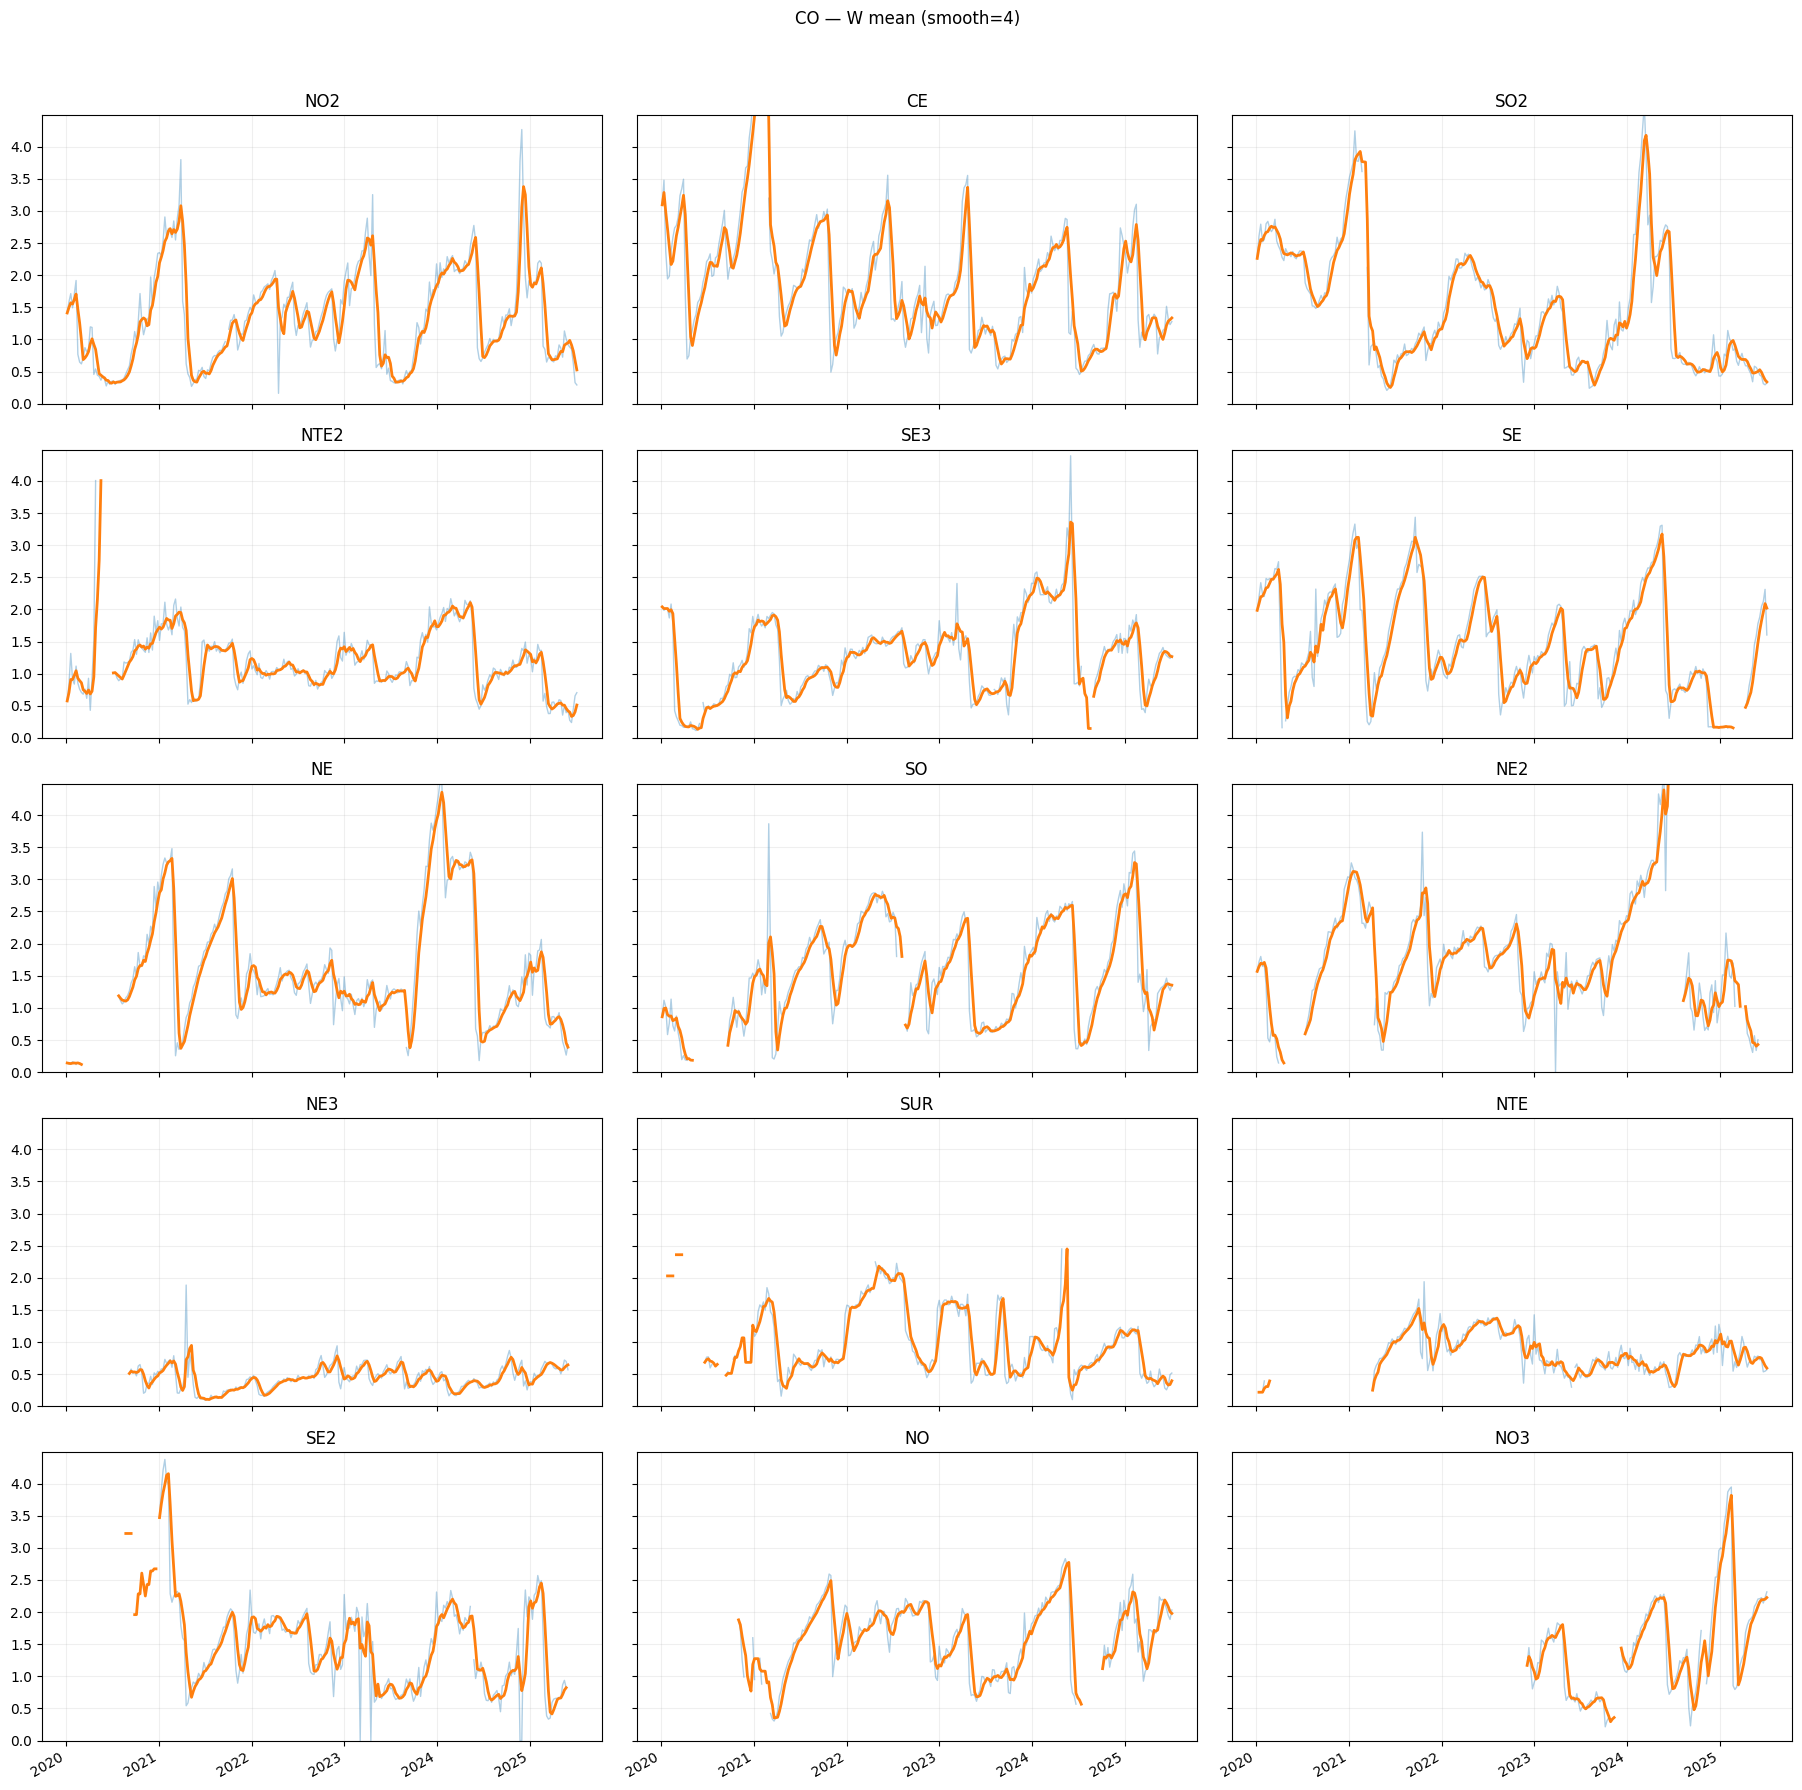

In [35]:
plot_contaminant_simple(df, "CO", freq="W", top_k=20, smooth=4, cap_q=0.995)